### USAGE
- Change the path to models generated by `cnn_baseline.py` (if needed).
- Change the `model_name` with the output name of `cnn_baseline.py` script, which is also the folder name containing 10 fold cross validation data.
- Run all code blocks.

In [6]:
import torch
import h5py
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef
from torch.nn.functional import cross_entropy
from math import sqrt
import pickle
import re
import pandas as pd
import os
import time
def get_metrics(metrics_f):
    # Load the metrics file:
    h5 = h5py.File(metrics_f)
    h5_keys = list(h5.keys())
    if len(h5_keys) == 0:
        return [None for x in range(17)]

    # Retrieve test metrics from the best model (5/CNN/I/classification/struct/cnn_performances.py output)
    # associated to the metrics data:
    #model_name = re.search(r"(?<=/trained_models/)[a-z0-9_]*(?=/)", metrics_f, re.IGNORECASE).group(0) # folder name extracted from the path
    model_name = 'CnnClassificationBaseline'
    # using regular expression
    #fold = re.search(r"(?<=/)[0-9](?=/)", metrics_f).group(0) # current fold (from 0 to 10)
    #test_data_f = f"/projects/0/einf2380/data/pMHCII/trained_models/CNN/classification/hla_drb1_0101_15mers/struct/{model_name}/shuffled/{fold}/metrics.hdf5" # retrieve the 
    # associated performances of the best model of this fold
    #test_h5 = h5py.File(test_data_f)
    test_h5 = h5py.File(metrics_f)

    logit = torch.tensor(test_h5["epoch_0012/test/outputs"]) # raw probability
    pred = logit.max(1)[1] # rounded probability
    targets = torch.tensor(test_h5["epoch_0012/test/targets"])

    confusion = pred/targets # absolute values for metrics
    tot = targets.shape[0] # total number of prediction
    pos = float((targets == 1.).sum()) # total number of positives (truth 1)
    neg = float((targets == 0.).sum()) # total number of negatives (truth 0)

    best_model_test_tpr = float((confusion == 1.).sum()/pos) # true prositive rate = prediction 1/truth 1
    best_model_test_tnr = float((torch.isnan(confusion)).sum()/neg) # true prositive rate = prediction 1/truth 1
    best_model_test_accuracy = float((pred==targets).sum()/tot)
    roc_tpr, roc_fpr, _ = roc_curve(targets, logit.max(1)[0], pos_label=1.)
    best_model_test_auc = auc(roc_fpr, roc_tpr)
    best_model_test_mcc = matthews_corrcoef(targets, pred)

    train_tpr = []
    train_losses = []
    train_tnr = []
    train_accuracies = []

    valid_tpr = []
    valid_losses = []
    valid_tnr = []
    valid_accuracies = []

    test_tpr = []
    test_losses = []
    test_tnr = []
    test_accuracies = []

    for key in h5_keys:
        if "epoch_" in key:
            train_outputs = torch.tensor(h5[key]["train"]["outputs"], dtype=torch.float)
            valid_outputs = torch.tensor(h5[key]["valid"]["outputs"], dtype=torch.float)
            test_outputs = torch.tensor(h5[key]["test"]["outputs"], dtype=torch.float)

            train_labels = torch.tensor(h5[key]["train"]["targets"])
            valid_labels = torch.tensor(h5[key]["valid"]["targets"])
            test_labels = torch.tensor(h5[key]["test"]["targets"])

            
            train_tpr.append(h5[key]["train"]["tpr"][()])
            train_tnr.append(h5[key]["train"]["tnr"][()])
            train_accuracies.append(h5[key]["train"]["acc"][()])
            train_losses.append(cross_entropy(train_outputs, train_labels))

            valid_tpr.append(h5[key]["valid"]["tpr"][()])
            valid_tnr.append(h5[key]["valid"]["tnr"][()])
            valid_accuracies.append(h5[key]["valid"]["acc"][()])
            valid_losses.append(cross_entropy(valid_outputs, valid_labels))

            test_tpr.append(h5[key]["test"]["tpr"][()])
            test_tnr.append(h5[key]["test"]["tnr"][()])
            test_accuracies.append(h5[key]["test"]["acc"][()])
            test_losses.append(cross_entropy(test_outputs, test_labels))

    return \
        best_model_test_tpr, best_model_test_tnr, \
        best_model_test_auc, best_model_test_mcc, best_model_test_accuracy,\
        train_accuracies, valid_accuracies, test_accuracies,\
        train_tpr, valid_tpr, test_tpr,\
        train_tnr, valid_tnr, test_tnr,\
        train_losses, valid_losses, test_losses

def save_best_metrics(model_name, test_best_tpr, test_best_tnr, test_auc, test_mcc,
    test_best_accuracies, outfile=True):
    d = {
        "sensitivity_mean": [float(test_best_tpr.mean())],
        "sensitivity_std": [float(test_best_tpr.std())],
        "specificity_mean": [float(test_best_tnr.mean())],
        "specificity_std": [float(test_best_tnr.std())],
        "auc_mean": [float(test_auc.mean())],
        "auc_std": [float(test_auc.std())],
        "mcc_mean": [float(test_mcc.mean())],
        "mcc_std": [float(test_mcc.std())],
        "accuracy_mean": [float(test_best_accuracies.mean())],
        "accuracy_std": [float(test_best_accuracies.std())],
        "model_path": [model_name],
    }
    df = pd.DataFrame(d)
    if type(outfile) == str:
        metrics_csv_path = outfile
    elif outfile:
        metrics_csv_path = "./best_models_metrics.csv"
    else:
        return None
    
    if os.path.exists(metrics_csv_path):
        csv_df = pd.read_csv(metrics_csv_path)
        concat_df = pd.concat([csv_df, df])
        concat_df.to_csv(metrics_csv_path, index=False)
    else:
        df.to_csv(metrics_csv_path, index=False)

def format_metrics(model_name, models_path, save = False):
    #model_name = "shuffled" # This line is the input for the model name
    #models_path = "/projects/0/einf2380/data/pMHCII/trained_models/CNN/classification/hla_drb1_0101_15mers/struct/CnnClassificationBaseline/" # Path where all models are located
    metrics_files = glob.glob(f"{models_path}/{model_name}/*/metrics.hdf5")

    all_best_model_train_tpr, all_best_model_train_tnr, \
    best_model_test_aucs, best_model_test_mccs, best_model_test_accuracies,\
    all_train_accuracies, all_valid_accuracies, all_test_accuracies, \
    all_train_tpr, all_valid_tpr, all_test_tpr, \
    all_train_tnr, all_valid_tnr, all_test_tnr, \
    all_train_losses, all_valid_losses, all_test_losses = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]

    correctly_trained = 0
    for metrics_file in metrics_files:
        t0 = time.time()
        best_model_train_tpr, best_model_train_tnr, \
        best_model_test_auc, best_model_test_mcc, best_model_test_accuracy, \
        train_accuracy, valid_accuracy, test_accuracy, \
        train_tpr, valid_tpr, test_tpr, \
        train_tnr, valid_tnr, test_tnr, \
        train_losses, valid_losses, test_losses = get_metrics(metrics_file)
        t1 = time.time()
        print(f'Getting metrics took {t1-t0} seconds')


        if best_model_train_tpr == None:
            continue
        else:
            correctly_trained += 1

        all_best_model_train_tpr.append(best_model_train_tpr)
        all_best_model_train_tnr.append(best_model_train_tnr)

        best_model_test_aucs.append(best_model_test_auc)
        best_model_test_mccs.append(best_model_test_mcc)
        best_model_test_accuracies.append(best_model_test_accuracy)
        
        all_train_accuracies.append(train_accuracy)
        all_valid_accuracies.append(valid_accuracy)
        all_test_accuracies.append(test_accuracy)
        
        all_train_tpr.append(train_tpr)
        all_valid_tpr.append(valid_tpr)
        all_test_tpr.append(test_tpr)

        all_train_tnr.append(train_tnr)
        all_valid_tnr.append(valid_tnr)
        all_test_tnr.append(test_tnr)

        all_train_losses.append(train_losses)
        all_valid_losses.append(valid_losses)
        all_test_losses.append(test_losses)

    test_auc = torch.tensor(best_model_test_aucs)
    test_mcc = torch.tensor(best_model_test_mccs)
    test_best_tpr = torch.tensor(all_best_model_train_tpr)
    test_best_tnr = torch.tensor(all_best_model_train_tnr)
    test_best_accuracies = torch.tensor(best_model_test_accuracies)

    train_accuracies = torch.permute(torch.tensor(all_train_accuracies), (1,0))
    valid_accuracies = torch.permute(torch.tensor(all_valid_accuracies), (1,0))
    test_accuracies = torch.permute(torch.tensor(all_test_accuracies), (1,0))

    train_tpr = torch.permute(torch.tensor(all_train_tpr), (1,0))
    valid_tpr = torch.permute(torch.tensor(all_valid_tpr), (1,0))
    test_tpr = torch.permute(torch.tensor(all_test_tpr), (1,0))

    train_tnr = torch.permute(torch.tensor(all_train_tnr), (1,0))
    valid_tnr = torch.permute(torch.tensor(all_valid_tnr), (1,0))
    test_tnr = torch.permute(torch.tensor(all_test_tnr), (1,0))

    train_losses = torch.permute(torch.tensor(all_train_losses), (1,0))
    valid_losses = torch.permute(torch.tensor(all_valid_losses), (1,0))
    test_losses = torch.permute(torch.tensor(all_test_losses), (1,0))
    t2 = time.time()
    print(f'Permuting took {t2-t1} seconds')

    def plot_metrics():
        fig = plt.figure(figsize=(18,15))
        ((ax1, ax2), (ax3, ax4)) = fig.subplots(2, 2)
        fig.suptitle(f"CNN performances on {model_name} data", color="red", fontsize=18)
        fig.text(
            0.15,1,
            f"\n\
                 AUC: {test_auc.mean():.3} \n\
                 MCC: {test_mcc.mean():.3} \n\
                 Accuracy on test set: {test_accuracies.mean():.3} \n\
                 Sensitivity: {test_tpr.mean():.3} \n\
                 Specificity: {test_tnr.mean():.3}",
            horizontalalignment="left",
            verticalalignment="top",
            fontweight=700,
            fontsize=12.5
        )

        e = range(train_accuracies.shape[0])
        ax1.plot(e, train_accuracies)
        ax1.plot(e, valid_accuracies)
        ax1.plot(e, test_accuracies)
        ax1.set_ylabel("Accuracy")
        ax1.set_title(f"Accuracies evolution for {correctly_trained} models over epochs")
        ax1.set_ylim(.5, 1)

        ax2.plot(e, train_accuracies.mean(1))
        ax2.plot(e, valid_accuracies.mean(1))
        ax2.plot(e, test_accuracies.mean(1))
        ax2.set_title("Mean accuracies")
        ax2.legend(["Training", "Validation", "Test"])
        ax2.set_ylim(.5, 1)

        ax3.plot(e, train_losses)
        ax3.plot(e, valid_losses)
        ax3.plot(e, test_losses)
        ax3.set_ylabel("Loss")
        ax3.set_title(f"Learning curve of {correctly_trained} models over epochs")

        ax4.plot(e, train_losses.mean(1))
        ax4.plot(e, valid_losses.mean(1))
        ax4.plot(e, test_losses.mean(1))
        ax4.set_title("Mean learning curves")
        ax4.legend(["Training", "Validation", "Test"])

        fig.subplots_adjust(
            wspace=.2,
            hspace=.3
        )
        fig.show()
        fig.savefig(f"./{model_name}_results.png", transparent=False, facecolor="white")

    plot_metrics()
    t3 = time.time()
    print(f'Plotting took {t3-t2} seconds')
    if save:
        save_best_metrics(model_name, test_best_tpr, test_best_tnr, 
            test_auc, test_mcc, test_best_accuracies, outfile=save)


In [5]:
'''
save_best_metrics(model_name, test_best_tpr, test_best_tnr, test_auc, test_mcc,
    test_best_accuracies    
)
'''

'\nsave_best_metrics(model_name, test_best_tpr, test_best_tnr, test_auc, test_mcc,\n    test_best_accuracies    \n)\n'

In [2]:
model_name = "shuffled" # This line is the input for the model name
#models_path = "/projects/0/einf2380/data/pMHCII/trained_models/CNN/classification/hla_drb1_0101_15mers/struct/CnnClassificationBaseline/" # Path where all models are located
models_path = "/projects/0/einf2380/data/pMHCII/trained_models/CNN/classification/hla_drb1_0101_15mers_4conv/struct/CnnClassification4Conv/"
format_metrics(model_name, models_path)

/scratch-local/dmarz/ipykernel_2337611/2193053365.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/torch/csrc/utils/tensor_new.cpp:201.)
  logit = torch.tensor(test_h5["epoch_0012/test/outputs"]) # raw probability


Getting metrics took 15.52138638496399 seconds
Getting metrics took 32.3986713886261 seconds
Getting metrics took 12.695638418197632 seconds
Getting metrics took 15.401652336120605 seconds
Getting metrics took 14.198312520980835 seconds
Getting metrics took 14.901317834854126 seconds


OSError: Unable to open file (truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2048)

Getting metrics took 12.689591884613037 seconds
Getting metrics took 15.698468208312988 seconds
Getting metrics took 13.104584693908691 seconds
Getting metrics took 10.899346113204956 seconds
Getting metrics took 12.496865272521973 seconds
Getting metrics took 11.898930788040161 seconds
Getting metrics took 10.31693720817566 seconds
Getting metrics took 12.481435060501099 seconds
Getting metrics took 14.201083421707153 seconds
Getting metrics took 10.005160570144653 seconds
Permuting took 0.09357237815856934 seconds
Plotting took 0.9024033546447754 seconds


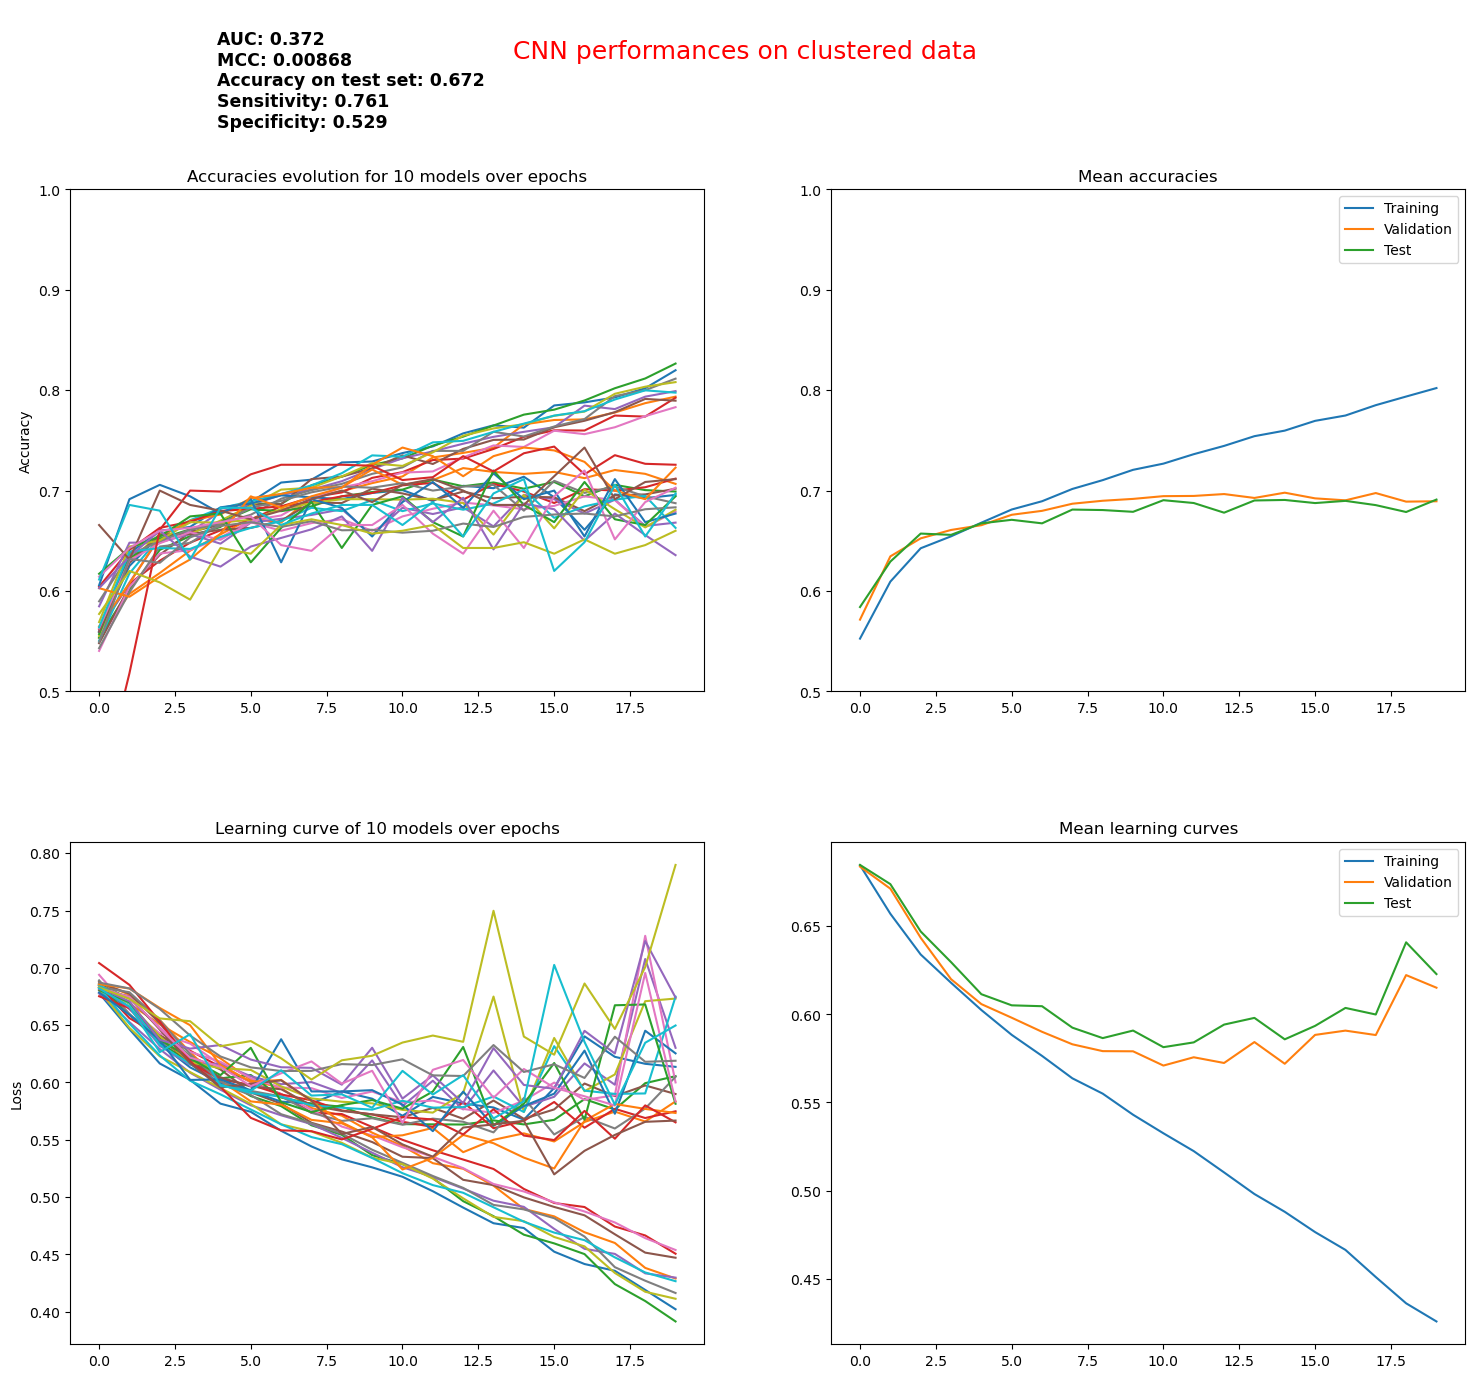

In [7]:
model_name = "clustered" # This line is the input for the model name
#models_path = "/projects/0/einf2380/data/pMHCII/trained_models/CNN/classification/hla_drb1_0101_15mers/struct/CnnClassificationBaseline/" # Path where all models are located
models_path = "/projects/0/einf2380/data/pMHCII/trained_models/CNN/classification/hla_drb1_0101_15mers_4conv/struct/CnnClassification4Conv/"
format_metrics(model_name, models_path)

Getting metrics took 12.350366353988647 seconds
Getting metrics took 14.902990102767944 seconds
Getting metrics took 13.295152187347412 seconds
Getting metrics took 12.100812435150146 seconds
Getting metrics took 14.502113103866577 seconds
Getting metrics took 12.096511363983154 seconds
Getting metrics took 13.602122783660889 seconds
Getting metrics took 14.297454833984375 seconds
Getting metrics took 12.000480651855469 seconds
Getting metrics took 13.003116130828857 seconds
Permuting took 0.09734058380126953 seconds
Plotting took 1.2529489994049072 seconds


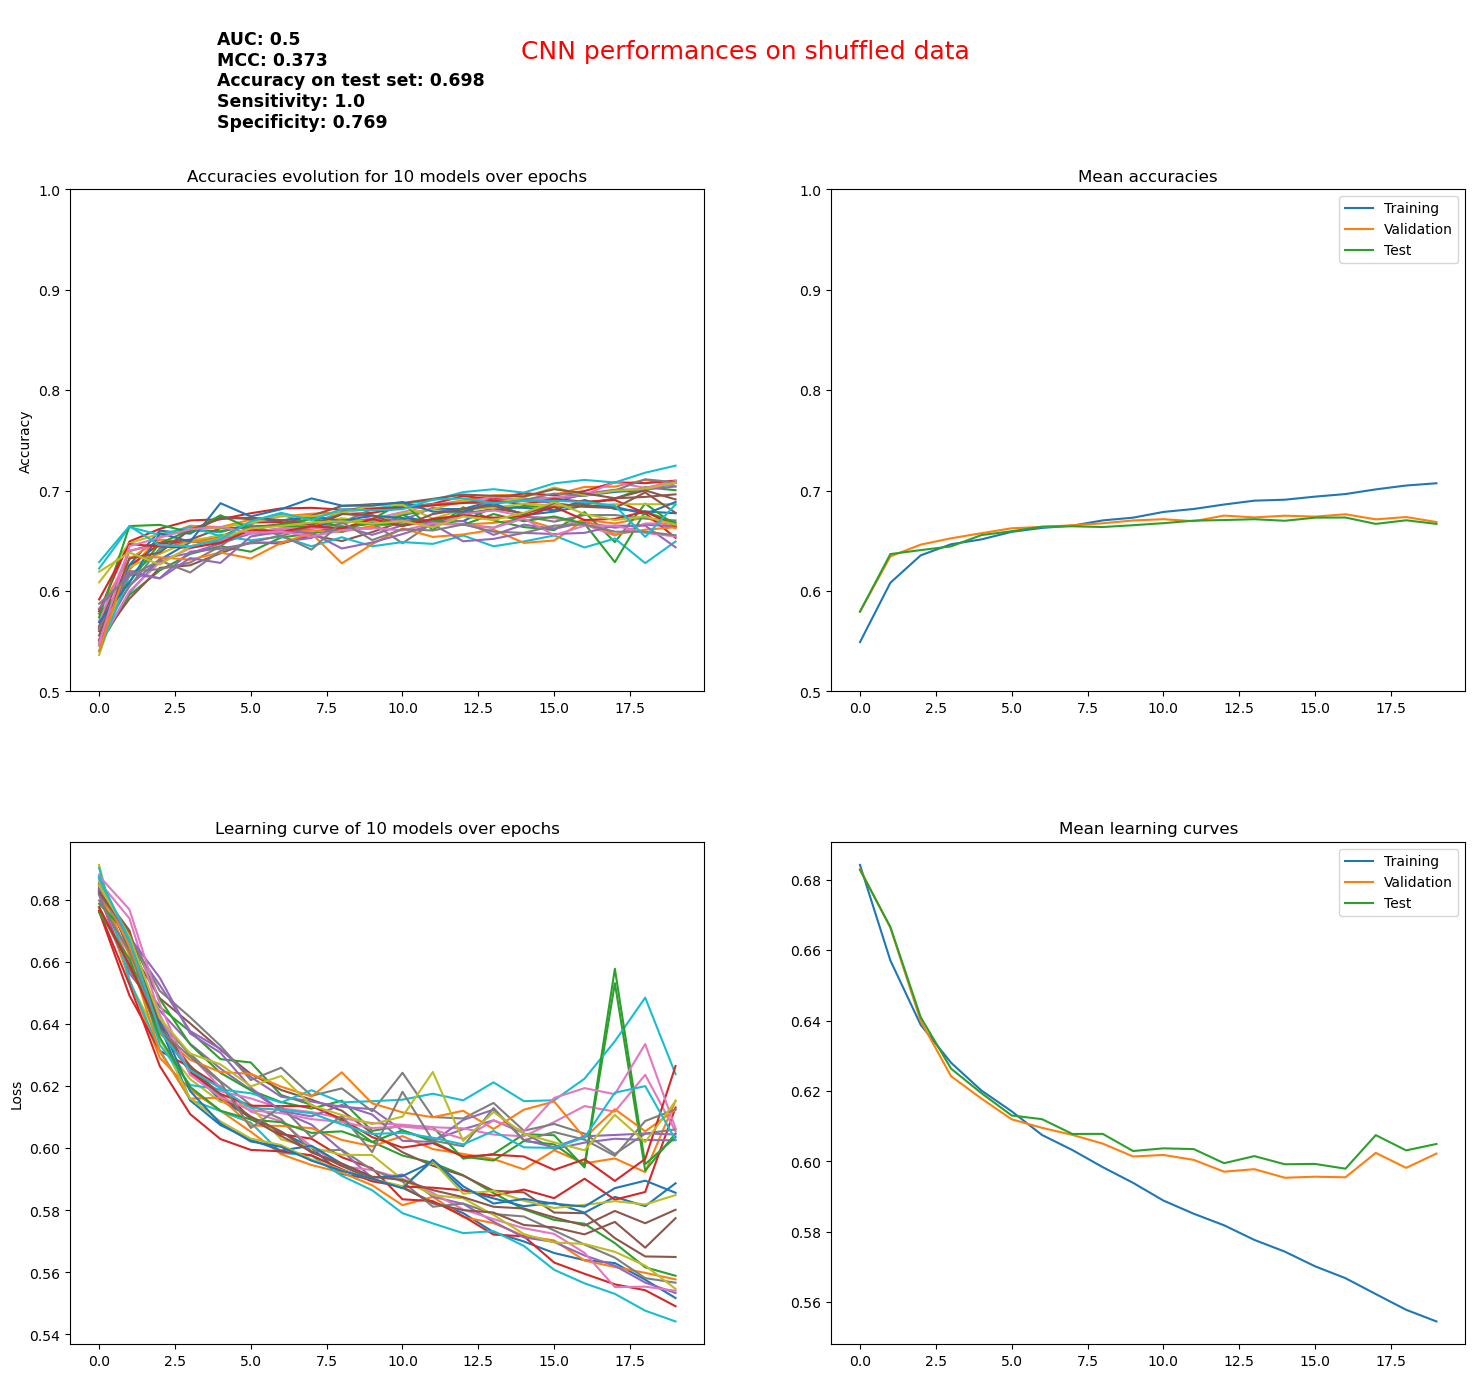

In [5]:
model_name = "shuffled" # This line is the input for the model name
#models_path = "/projects/0/einf2380/data/pMHCII/trained_models/CNN/classification/hla_drb1_0101_15mers/struct/CnnClassificationBaseline/" # Path where all models are located
models_path = "/projects/0/einf2380/data/pMHCII/trained_models/CNN/classification/hla_drb1_0101_15mers_4conv_noPSSM/struct/CnnClassification4Conv/"
format_metrics(model_name, models_path, save=True)

Getting metrics took 11.82810378074646 seconds
Getting metrics took 9.802526950836182 seconds
Getting metrics took 9.999532222747803 seconds
Getting metrics took 9.399344205856323 seconds
Getting metrics took 9.797468662261963 seconds
Getting metrics took 9.800022840499878 seconds
Getting metrics took 10.00058650970459 seconds
Getting metrics took 9.398308038711548 seconds
Getting metrics took 9.30164623260498 seconds
Getting metrics took 9.804139852523804 seconds
Permuting took 0.002319812774658203 seconds
Plotting took 0.8663866519927979 seconds


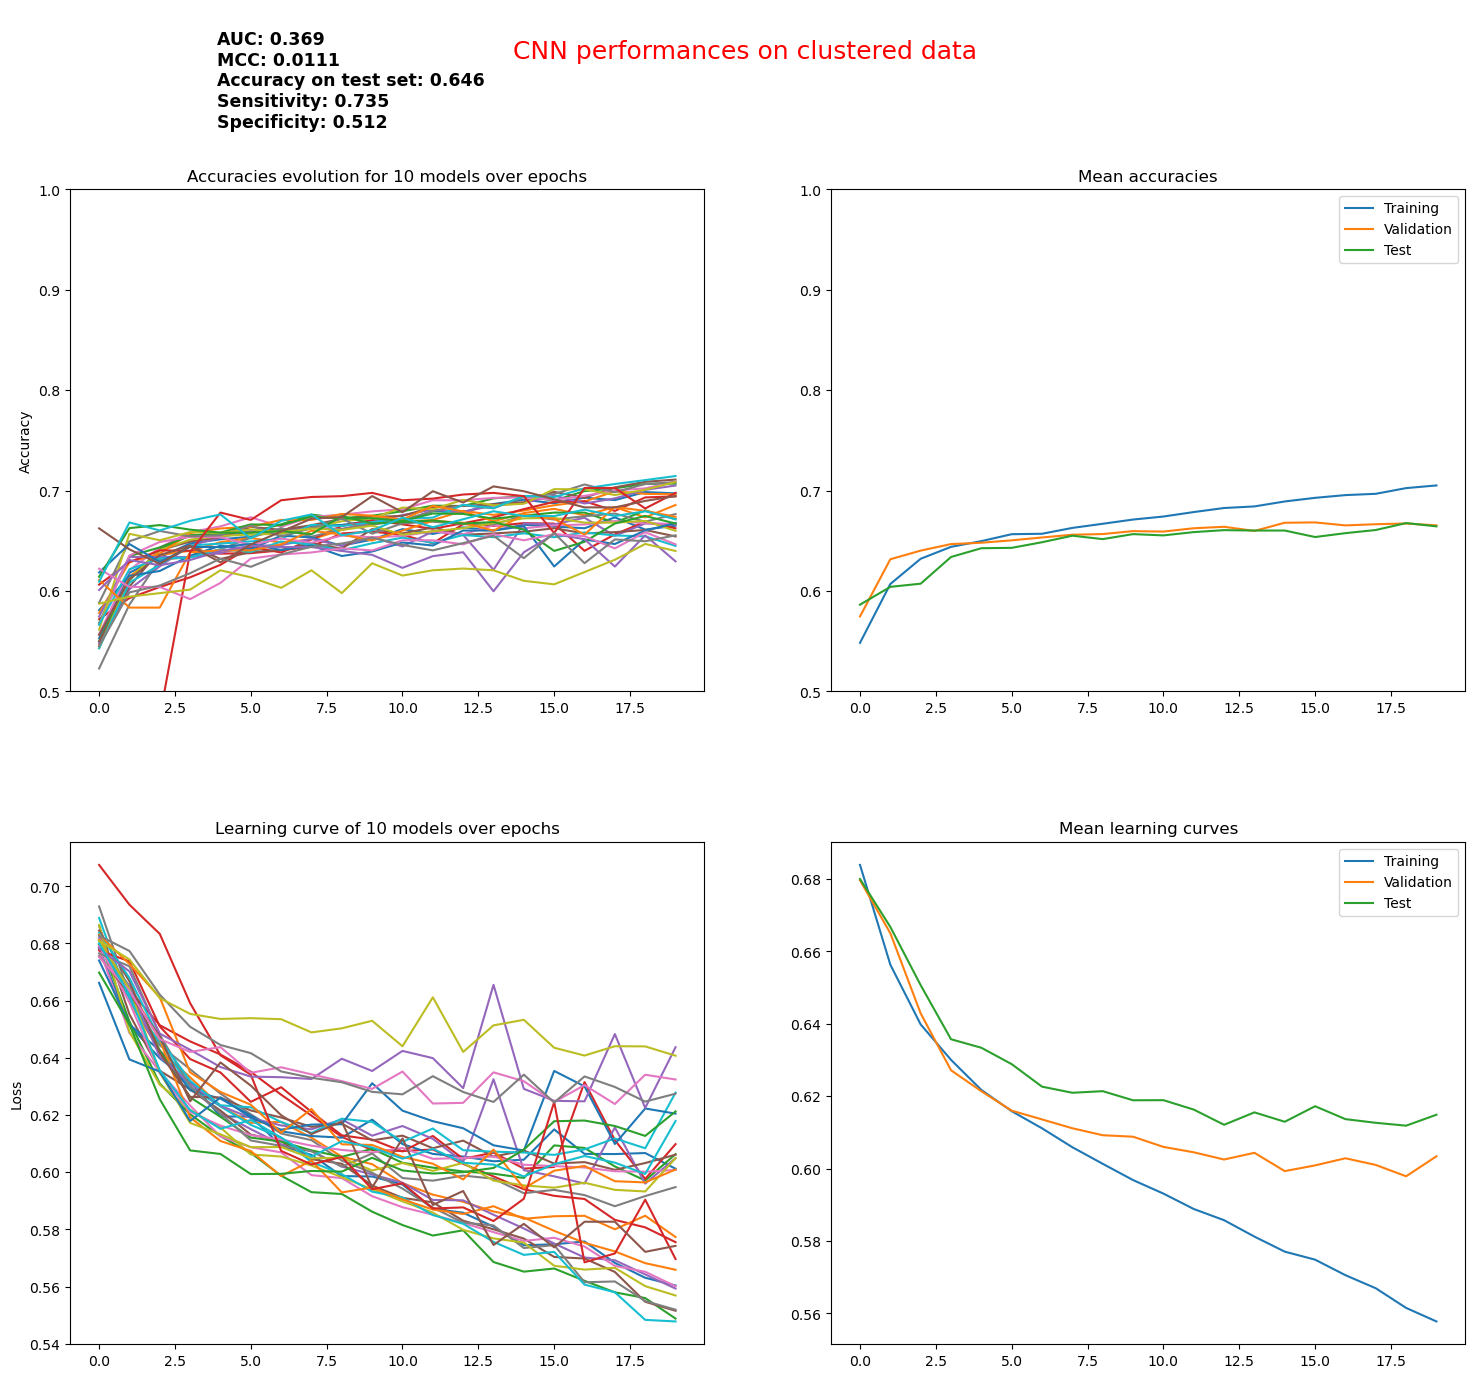

In [3]:
model_name = "clustered" # This line is the input for the model name
#models_path = "/projects/0/einf2380/data/pMHCII/trained_models/CNN/classification/hla_drb1_0101_15mers/struct/CnnClassificationBaseline/" # Path where all models are located
models_path = "/projects/0/einf2380/data/pMHCII/trained_models/CNN/classification/hla_drb1_0101_15mers_4conv_noPSSM/struct/CnnClassification4Conv/"
format_metrics(model_name, models_path, save=True)